In [1]:
#  import libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Input, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, MaxPooling2D

#  import mse loss function
from tensorflow.keras.losses import mse


### What is an autoencoder?

An autoencoder is a type of neural network that is used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. 

Autoencoders are data-specific, which means that if you train an autoencoder on one set of data, then it will not necessarily be able to reduce any other data. For this reason, they are most useful as a pre-processing step for another machine learning algorithm rather than as a standalone model.



# STACKED AUTOENCODER

### What is a stacked autoencoder?

A stacked autoencoder have multiple hidden layers. Adding more layers to the autoencoder allows it to learn more complex representations of the input data. The first hidden layer of the autoencoder learns to extract the most basic features of the input data, and each subsequent hidden layer builds on the features learned by the previous layers. The architecture of a stacked autoencoder is symmetrical with regards to the central hidden layer. It looks like a sandwitch.

The architecture of a stacked autoencoder is typically symmetrical with regards to the
central hidden layer (the coding layer). To put it simply, it looks like a sandwich.

In [2]:
#  import regularizer for the convolutional layers
from tensorflow.keras import regularizers

In [ ]:
class StackedAutoEncoder:

    def __init__(self, input_dim, batch_size = 32, learning_rate = 1e-5):
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None
        self._build()

    def _build(self):

        #  input layer 
        x = Input(shape=(self.input_dim, self.input_dim, 1), name='encoder_input')
        # Input layer is 28x28x1 (wide and high)

        #  encoder
        #  convolutional layer
        conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
        #  convolutional layer
        conv2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv1)
        #  max pooling layer
        pool1 = MaxPool2D(pool_size=(2, 2))(conv2)
        #  convolutional layer
        conv3 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
        #  convolutional layer
        conv4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv3)
        #  max pooling layer
        pool2 = MaxPool2D(pool_size=(2, 2))(conv4)


        #  decoder
        #  upsampling layer
        up1 = UpSampling2D(size=(2, 2))(pool2)
        #  convolutional layer
        conv7 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(up1)
        #  convolutional layer
        conv8 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv7)
        #  upsampling layer
        up2 = UpSampling2D(size=(2, 2))(conv8)
        #  convolutional layer
        conv9 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(up2)
        #  convolutional layer
        conv10 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv9)

        #  output layer
        output = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv10)

        self.model = Model(x, output)

        self.model.compile(optimizer=Adam(lr=self.learning_rate), loss='mse')

        self.model.summary()



### Creating Model and Testing Them

In [ ]:
# import the data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


### Importing Dataset

In [ ]:
# data mnsit 

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.

x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))



In [ ]:
# shape of the data

print(x_train.shape)

print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Data Sampling

In [ ]:
#  stratify sample 6000 images from the training set and 100 images from the test set

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_train)



**Creating the Stacked Autoencoder**

In [ ]:
#  stack autoencoder
sae = StackedAutoEncoder(input_dim=28)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                             

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Training the Stacked Autoencoder**

In [ ]:
#  train the model
sae.model.fit(x_train, x_train, epochs=30, validation_data=(x_val, x_val))

Epoch 1/30
1688/1688 [==============================] - 12s 5ms/step - loss: 0.0480 - val_loss: 0.0091
Epoch 2/30
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 3/30
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 4/30
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 5/30
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/30
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 7/30
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/30
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/30
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 10/30
1688/1688 [==============================] - 9s 5ms/step - loss: 0.00

In [ ]:
# Evaluating the models
sae.model.evaluate(x_test, x_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0011


0.0011129977647215128

In [ ]:
# test the model on random image input
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test[0:1]
x_test.shape

(1, 28, 28, 1)

1/1 [==============================] - 0s 152ms/step
Input


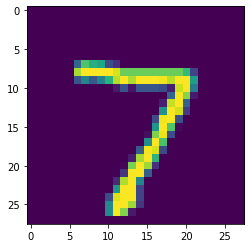

Output from Stacked Auto Encoder


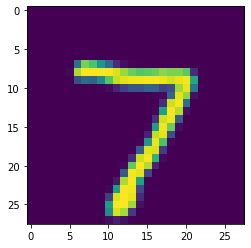

In [ ]:
#  predict the output
x_pred = sae.model.predict(x_test)

 # plot the input and output
plt.figure(figsize=(20, 4))
print("Input")
for i in range(0,1):
    plt.imshow(x_test[i].reshape(28, 28))
plt.show()

plt.figure(figsize=(20, 4))
print("Output from Stacked Auto Encoder")
for i in range(0,1):
    plt.imshow(x_pred[i].reshape(28, 28))
plt.show()